# Trabajo Investigación JAX
## Por Marcos García Estévez

Fuentes usadas:
- https://es.statisticseasily.com/glosario/what-is-jax-high-performance-computing/
- https://opensource.googleblog.com/2024/12/a-robust-open-ecosystem-accelerating-ai-infrastructure.html
- https://github.com/jax-ml/jax-ai-stack
- https://github.com/n2cholas/awesome-jax

## 1. **Qué es JAX y cuáles son sus principales características.**

JAX es una biblioteca de código abierto desarrollada por Google diseñada para computación numérica de alto rendimiento y aplicaciones de aprendizaje automático. Combina la simplicidad de la API de NumPy con capacidades avanzadas como la paralelización o aceleración mediante GPU/TPU. Sus otras características incluyen:

- Diferenciación automática: Permite calcular gradientes de funciones de manera eficiente, esencial para optimización y entrenamiento de modelos.

- Compilación JIT (Just-In-Time): Optimiza el rendimiento al compilar código Python en instrucciones de máquina aceleradas mediante XLA.

- Compatibilidad con NumPy: Facilita la transición para usuarios familiarizados con NumPy, manteniendo una sintaxis similar.

Programación funcional: Fomenta un enfoque inmutable y libre de efectos secundarios, mejorando la previsibilidad del código.

Aceleración en hardware: Soporte nativo para GPU, TPU y nuevos chips como AWS Trainium.

## 2. **Comparación de JAX con TensorFlow y PyTorch.**


| Característica      | JAX                                         | TensorFlow                                    | PyTorch                                       |
|---------------------|---------------------------------------------|---------------------------------------------|---------------------------------------------|
| Paradigma           | Programación funcional                     | Estático/dinámico (Eager Mode)              | Dinámico (prioriza flexibilidad)             |
| Rendimiento         | Optimizado con XLA (alta eficiencia en TPU/GPU) | Bueno para producción, menos eficiente en investigación | Menor optimización que JAX pero excelente para prototipado |
| Autodiferenciación  | Gradientes de orden superior (Hessianas)    | GradientTape (solo primer orden)            | Autograd (flexible pero menos eficiente)     |
| Ecosistema          | En crecimiento (Flax, Haiku)               | Maduro (Keras, TFX)                         | Amplio (TorchVision, Lightning)             |
| Casos de uso        | Investigación, cómputo científico          | Producción empresarial                      | Academia y prototipado rápido               |

### **Ventajas de JAX**:
1. Ideal para modelos matemáticamente intensivos (ej: física diferenciable, optimización avanzada).
2. Escalabilidad en entornos distribuidos gracias a `pmap` y `vmap`.

### **Desventajas:**
1. Curva de aprendizaje más pronunciada por su enfoque funcional.
2. Menor soporte para despliegue en producción comparado con TensorFlow.


## 3. **Ecosistema: librerías implementadas sobre JAX y otras herramientas que se integran bien con esta tecnología.**

## Librerías de redes neuronales:

- **Flax**: Ofrece una API de alto nivel para la construcción de modelos neuronales en JAX, facilitando la definición de redes complejas con módulos reutilizables y una sintaxis clara.

- **Haiku**: Desarrollada por DeepMind, proporciona una interfaz simple y potente para crear modelos en JAX, permitiendo una fácil transición desde otros frameworks como TensorFlow o PyTorch.

- **Optax**: Una biblioteca integral para la optimización en JAX, que incluye una amplia gama de optimizadores, funciones de pérdida y herramientas para el procesamiento de gradientes.

## Herramientas científicas:

- **JAX-MD**: Facilita la realización de simulaciones de dinámica molecular totalmente diferenciables, permitiendo estudios avanzados en física y química computacional.

- **NumPyro**: Ofrece un marco de programación probabilística que combina la simplicidad de NumPy con la potencia de JAX para modelado estadístico y aprendizaje automático bayesiano.

## Integraciones externas:

- **TensorFlow Datasets**: Proporciona una colección de conjuntos de datos listos para usar con JAX, simplificando el proceso de carga y preprocesamiento de datos para entrenamiento de modelos.

- **HuggingFace Transformers**: Permite el uso de modelos de lenguaje preentrenados en Flax, facilitando la implementación de aplicaciones de procesamiento de lenguaje natural de última generación.

## Stack empresarial:

Google promueve el **JAX AI Stack**, que incluye Flax, Optax y herramientas como Orbax para la persistencia de modelos, ofreciendo una solución completa para el desarrollo y despliegue de aplicaciones de inteligencia artificial escalables y eficientes.


## 4. **Ejemplo práctico.**

Para este ejemplo práctico voy a utilizar el dataset "Bank Marketing" de UCI (disponible en scikit-learn via fetch_openml), que es un problema de clasificación binaria para predecir si un cliente suscribirá un depósito bancario.

Implementaré el mismo entrenamiento usando: tensorflow, pytorch y JAX. De esta forma, podremos comparar lineas de codigos y tiempo de entrenamiento para cada uno. Concretamente, una capa oculta de 64 neuronas, y una neurona de salida.

Para este primer paso, realizaremos el preprocesamiento.

In [1]:
import time
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml

# Cargar dataset
bank = fetch_openml(name="bank-marketing", version=1, as_frame=True)
X = bank.data
y = bank.target.cat.codes  # Convertir a 0/1

# Identificar columnas categóricas y numéricas
categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ])

X_processed = preprocessor.fit_transform(X)

# Guardar preprocesador y datos
joblib.dump(preprocessor, "preprocessor.joblib")
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
np.savez("train_test_data.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

## 4.1 **Tensorflow**

In [2]:
import tensorflow as tf
import time
import joblib
import numpy as np

data = np.load("train_test_data.npz")
X_train = data["X_train"].astype(np.float32)
y_train = data["y_train"].astype(np.float32)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy')

start_time = time.time()
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
training_time = time.time() - start_time

model.save("tf_model.keras")
joblib.dump(training_time, "tf_time.joblib")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


['tf_time.joblib']

Usando CPU, TensorFlow ha tardado en realizar el entrenamiento **3 minutos 40 segundos**.


## 4.2 **Pytorch**

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import joblib
import numpy as np

data = np.load("train_test_data.npz")
X_train = torch.tensor(data["X_train"].astype(np.float32))
y_train = torch.tensor(data["y_train"].astype(np.float32)).unsqueeze(1)

class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

model = Net(X_train.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start_time = time.time()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
training_time = time.time() - start_time

torch.save(model.state_dict(), "torch_model.pth")
joblib.dump(training_time, "torch_time.joblib")

['torch_time.joblib']

Usando CPU, Pytorch ha tardado en realizar el entrenamiento **17 segundos**.

## 4.3 **JAX**

In [4]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn
from flax.training import train_state
import numpy as np
import time

class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x

def create_train_state(rng, input_shape, learning_rate):
    model = MLP()
    params = model.init(rng, jnp.ones(input_shape))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['X'])
        loss = optax.sigmoid_binary_cross_entropy(logits.squeeze(), batch['y']).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    return state.apply_gradients(grads=grads)

# Cargar datos
data = np.load("train_test_data.npz")
X_train = jnp.array(data["X_train"].astype(np.float32))
y_train = jnp.array(data["y_train"].astype(np.float32))

# Entrenamiento
rng = jax.random.PRNGKey(0)
state = create_train_state(rng, (1, X_train.shape[1]), 0.001)
batch = {'X': X_train, 'y': y_train}

start_time = time.time()
for _ in range(100):
    state = train_step(state, batch)
training_time = time.time() - start_time

# Guardar modelo y tiempo
joblib.dump(state.params, "jax_params.joblib")
joblib.dump(training_time, "jax_time.joblib")

['jax_time.joblib']

Usando CPU, JAX ha tardado en realizar el entrenamiento **7 segundos**.

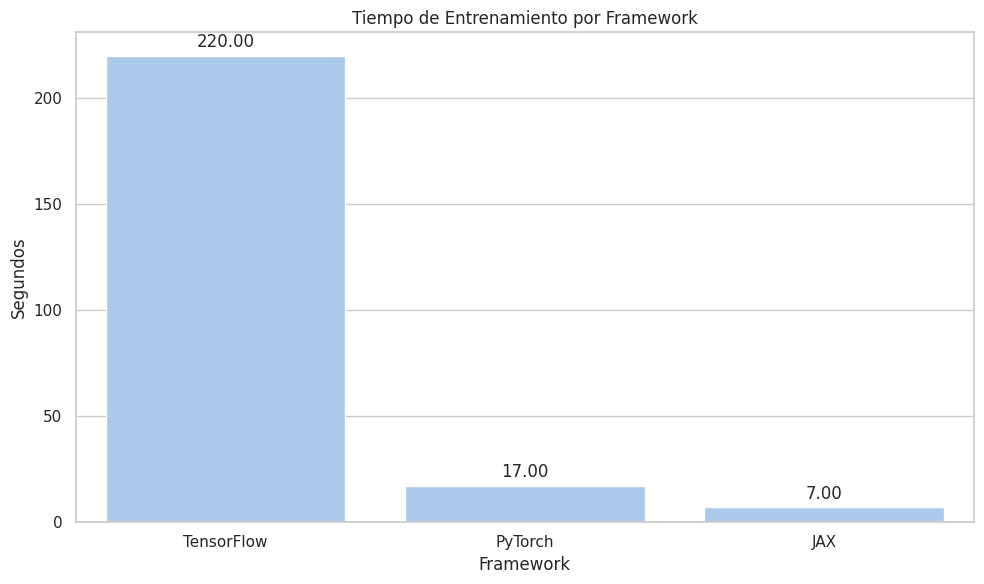

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurar estilo
sns.set_theme(style="whitegrid", palette="pastel")

# Tiempos de entrenamiento (en segundos)
training_times = {
    "TensorFlow": 3 * 60 + 40,  # 3 minutos 40 segundos
    "PyTorch": 17,              # 17 segundos
    "JAX": 7                    # 7 segundos
}

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(10, 6))

times_df = pd.DataFrame({
    "Framework": list(training_times.keys()),
    "Tiempo (s)": list(training_times.values())
})

sns.barplot(x="Framework", y="Tiempo (s)", data=times_df, ax=ax)
ax.set_title("Tiempo de Entrenamiento por Framework")
ax.set_ylabel("Segundos")
ax.set_xlabel("Framework")

# Añadir etiquetas a las barras
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

## 5. **Conclusiones**

Jax ha sido el más rápido a la hora de entrenar, y Tensorflow, con diferencia, el más lento.

Sin embargo, también ha sido el que menos líneas de código ha necesitado.

**Nota:** calculado usando cpu de google colab, los resultados pueden variar según la cpu utilizada.